# Marginal Uniformization

In this notebook, we are going to demonstrate how we do uniformization. Uniformization is when we turn any univariate distribution into a uniform distribution. This works by taking finding the CDF of a function

This is mainly used for inverse sampling but in theory, we can go from a uniform distribution to any other distribution but taking

In [1]:
import os, sys
from pyprojroot import here
# sys.path.insert(0, f"{cwd}/../")
sys.path.append(str(here()))

from rbig.data import ToyData
from rbig.transform.uniformization import HistogramUniformization, KDEUniformization

import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.reset_defaults()
sns.set_context(context='talk',font_scale=0.7)

%load_ext autoreload
%autoreload 2

## Data

In [2]:
def gen_uni_data(n_samples: 1_000, a: float, seed: int=123) -> np.ndarray:
    return stats.gamma(a=a).rvs(size=(n_samples, 1), random_state=seed)

In [3]:
# parameters
seed = 123
n_samples = 10_000
a = 4

# get some samples
X = gen_uni_data(n_samples, a, seed)

# plot distribution
sns.distplot(X)

So for this example, we are using a Beta distribution with an $\alpha$ value of 4 to generate a slightly skewed distribution.

## Gotcha I - Support Extension

The support extension is a parameter which extends the bounds of the datapoints used to fit the model. Without this extension, we will have problems transforming new data, sampling new data and estimating probabilities. 

### Histogram Estimation

The simplest way to fix this for the histogram estimation is to extend the range when estimating the histogram. This will put some bins past the minimum and maximum points of the input data. This will also affect the CDF and Quantile function. See the below code for a demonstration

In [4]:
supports = {}
cdfs = {}

In [5]:
# No support extension
hist_clf = HistogramUniformization(
    bins=1_000,
    support_extension=0,
).fit(X)
supports['hist'] = hist_clf.estimator_.estimator_._hbins
cdfs['hist'] = hist_clf.estimator_.estimator_._hcdf

# Extended support
hist_clf = HistogramUniformization(
    bins=1_000,
    support_extension=10,
).fit(X)
supports['hist_ext'] = hist_clf.estimator_.estimator_._hbins
cdfs['hist_ext'] = hist_clf.estimator_.estimator_._hcdf

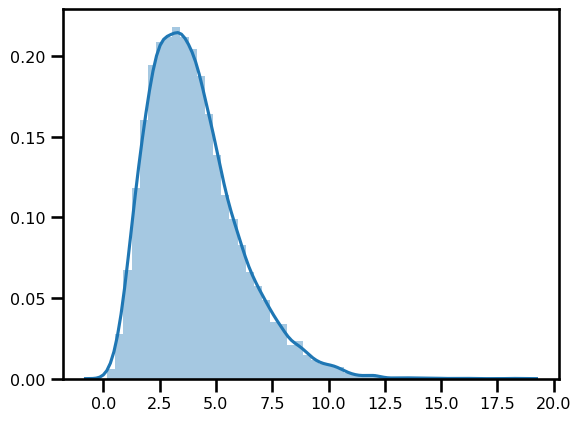

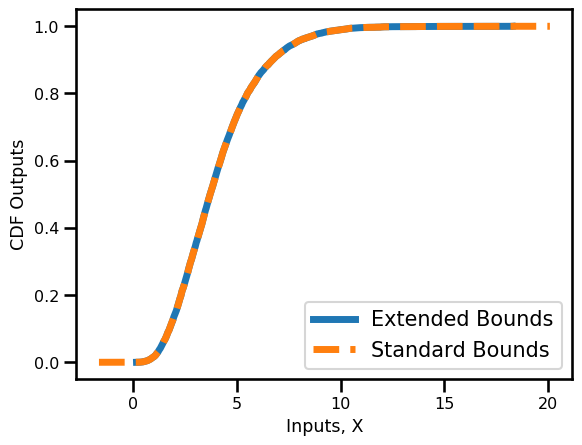

In [6]:
fig, ax = plt.subplots()
ax.plot(
    supports['hist'], cdfs['hist'], 
    label='Extended Bounds', linestyle='-',
    linewidth=5,
    )
ax.plot(
    supports['hist_ext'], cdfs['hist_ext'], 
    label='Standard Bounds', linestyle='--',
    linewidth=5
)
ax.legend(fontsize=15)
ax.set(
    xlabel='Inputs, X',
    ylabel='CDF Outputs')
plt.show()

A more complex procedure would be to actually do two interpolations where we essentially "squish" the CDF function. But that is a bit more complex and at that point, it might be worth it to use a different estimator.

### KDE Estimation

Similar to the histogram, we do something similar. In the case of the exact evaluations, the KDE PDF, CDF, and PPF will never be zero. However, when we do the interpolation (which is **much** faster), we need to ensure that the grid we use extends past the fitted support. In this case, we simply extend the grid such that we get more points even outside the range of the observed data.

In [12]:
# # No support extension
# kde_clf = KDEUniformization(
#     bw_method='scott',
#     support_extension=0,
#     method='epa',
#     kernel='epa',
# ).fit(X)
# supports['kde'] = kde_clf.estimator_.hbins_
# cdfs['kde'] = kde_clf.estimator_.hcdf_

# Extended support
kde_clf = KDEUniformization(
    bw_method='scott',
    support_extension=10,
    method='epa',
    kernel='epa',
).fit(X)
supports['kde_ext'] = kde_clf.estimator_.hbins_
cdfs['kde_ext'] = kde_clf.estimator_.hcdf_

-1.6427753195734345 20.086768817111505 (10002,)
-1.6417753195734346 20.085768817111504


ValueError: Every data point must be inside of the grid.

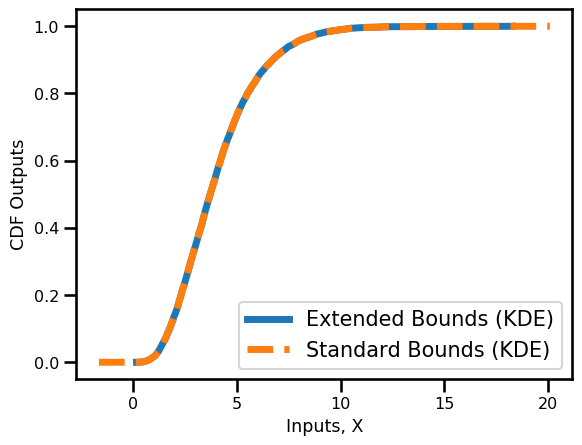

In [10]:
fig, ax = plt.subplots()
ax.plot(
    supports['kde'], cdfs['kde'], 
    label='Extended Bounds (KDE)', linestyle='-',
    linewidth=5,
    )
ax.plot(
    supports['kde_ext'], cdfs['kde_ext'], 
    label='Standard Bounds (KDE)', linestyle='--',
    linewidth=5
)

ax.legend(fontsize=15)
ax.set(
    xlabel='Inputs, X',
    ylabel='CDF Outputs')
plt.show()